In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.utils import save_image
from math import log2
from tqdm import tqdm


from Dataset_maker import get_loader,check_loader
from Mapping_Network import Weighted_scale_layer,Pixen_Norm,Mapping_Network
from Ada_IN_and_InsetNoise import Ada_IN,Inject_Noise
from Generator import Generator
from Discriminator import Discriminator
from Blocks import Weighted_Scale_Conv2d,Synthesis_Block,Conv_Block
from Gradient_penality import gradient_penalty
from Generatormix2 import Generatormix2

%matplotlib inline
import matplotlib.pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZES = [256,256,256,128,64,32,16]
PROGRESSIVE_EPOCHS = [1] * len(BATCH_SIZES)
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32,1/64]


def generate_examples(gen, steps, n=100):
    
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            img = gen(torch.randn(1, 512).to(DEVICE), alpha, steps)
            
            if not os.path.exists(f'saved_examples1/step{steps}'):
                os.makedirs(f'saved_examples1/step{steps}')
                
            save_image(img*0.5+0.5, f"saved_examples1/step{steps}/img_{i}.png")
            
    gen.train()


def Style_mixing(genmix,gen, steps,alpha2=0.5, n=10):
    
    genmix.eval()
    gen.eval()
    alpha = 1.0
    
    for i in range(n):
        with torch.no_grad():
            noise1 = torch.randn(1, 512).to(DEVICE)
            noise2 = torch.randn(1, 512).to(DEVICE)
            
            imgmix = genmix(noise1,noise2, alpha, steps,alpha2=alpha2)
            
            img1 = gen(noise1, alpha, steps)
            img2 = gen(noise2, alpha, steps)
            
            
            if not os.path.exists(f'style_Mix/mix{i}'):
                os.makedirs(f'style_Mix/mix{i}')
            
            
            save_image(imgmix*0.5+0.5, f"style_Mix/mix{i}/imgmix.png")
            
            save_image(img1*0.5+0.5, f"style_Mix/mix{i}/img1.png")
            save_image(img2*0.5+0.5, f"style_Mix/mix{i}/img2.png")
            
    genmix.train()
    gen.train()


def train_fn(critic,gen,loader,dataset,step,alpha,opt_critic,opt_gen):
        
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        
        real = real.to(DEVICE)
        batch_size = real.shape[0]
        Z_dimension = 512
        noise = torch.randn(batch_size, Z_dimension).to(DEVICE) 
        
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        detached_images = fake.detach()
        
        critic_fake = critic(detached_images, alpha, step)
        
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        
        loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ 10 * gp + (0.001) * torch.mean(critic_real ** 2))

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        lenght_dataset = len(dataset)

        alpha += batch_size / (PROGRESSIVE_EPOCHS[step] * 0.5 * lenght_dataset)
        
        alpha = min(alpha,1)
        
        loop.set_postfix(gp = gp.item(),loss_critic = loss_critic.item())
        
        
    return alpha



Loaded generator and discriminator weights from saved files.
<built-in method size of Tensor object at 0x7fc8250d6770>


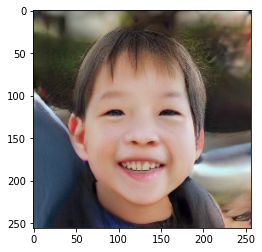

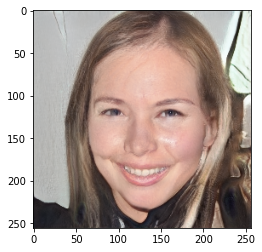

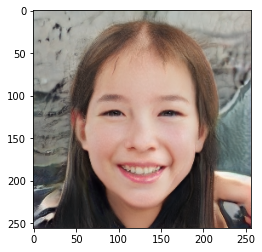

done


In [55]:

step_path = 'weights/step_num.pth'
gen_path = 'weights/generator_weights'

step_num = 6
torch.save(step_num, step_path)

gen = Generator(512, 512, 512, 3).to(DEVICE)  

genmix2 = Generatormix2(512, 512, 512, 3).to(DEVICE)  


try:
    step_num = torch.load(step_path)
    gen.load_state_dict(torch.load(gen_path+str(step_num)+'.pth'))
    genmix2.load_state_dict(torch.load(gen_path+str(step_num)+'.pth'))
    
    print('Loaded generator and discriminator weights from saved files.')
except:
    print('Starting training from scratch.')



alpha=1
steps=6

for i in range(10):
    with torch.no_grad():
        noise1 = torch.randn(1, 512).to(DEVICE)
        noise2 = torch.randn(1, 512).to(DEVICE)

        img1 = gen(noise1, alpha, steps)
        img2 = gen(noise2, alpha, steps)
        imgmix2 = genmix2(noise1,noise2, alpha, steps,0.5)
        
        
        if not os.path.exists(f'style_Mix/mix{i}'):
            os.makedirs(f'style_Mix/mix{i}')


        save_image(imgmix2*0.5+0.5, f"style_Mix/mix{i}/imgmix.png")
        
        save_image(img1*0.5+0.5, f"style_Mix/mix{i}/img1.png")
        save_image(img2*0.5+0.5, f"style_Mix/mix{i}/img2.png")
        
        
        plt.imshow((img1*0.5+0.5).cpu().squeeze().permute(1, 2, 0).numpy())
        plt.show()
        
        plt.imshow((img2*0.5+0.5).cpu().squeeze().permute(1, 2, 0).numpy())
        plt.show()
        
        plt.imshow((imgmix2*0.5+0.5).cpu().squeeze().permute(1, 2, 0).numpy())
        plt.show()
        
        
print("done")

In [57]:
step_path = 'weights/step_num.pth'
step_num = 6
torch.save(step_num, step_path)

import torch 

def main():
    
    gen_path = 'weights/generator_weights'
    critic_path = 'weights/discriminator_weights'
    step_path = 'weights/step_num.pth'
    
    gen = Generator(512, 512, 512, 3).to(DEVICE)  #Z_Dimension, W_Dimension, Input_channels, Out_Channels
    critic = Discriminator(512, 3).to(DEVICE)  #Input_channels, Out_channels 

    opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                         {'params': gen.map.parameters(), 'lr': 1e-5}], lr = 1e-3, betas =(0.0, 0.99))
    
    opt_critic = optim.Adam(critic.parameters(), lr = 1e-3, betas =(0.0, 0.99))

    gen.train()
    critic.train()
    
    try:
        step_num = torch.load(step_path)
        gen.load_state_dict(torch.load(gen_path+str(step_num)+'.pth'))
        critic.load_state_dict(torch.load(critic_path+str(step_num)+'.pth'))
        print('Loaded generator and discriminator weights from saved files.')
    except:
        step_num = 0
        print('Starting training from scratch.')
    
    
    for num_epochs in PROGRESSIVE_EPOCHS[step_num:]:
        
        current__Imagesize = 4*(2**step_num)
        alpha = 1e-7
        loader, dataset = get_loader(current__Imagesize)
        
        print('Current image size: ',current__Imagesize)

#         for epoch in range(num_epochs):
#             print(f'Epoch [{epoch + 1}/ {num_epochs}')
#             alpha = train_fn(critic, gen, loader, dataset, step_num, alpha, opt_critic, opt_gen)
        
        print("generating images")
        
        generate_examples(gen, step_num)
        
        step_num += 1
        
        torch.save(step_num, step_path)
        torch.save(gen.state_dict(), gen_path+str(step_num)+'.pth')
        torch.save(critic.state_dict(), critic_path+str(step_num)+'.pth')
        
        print('generated images of size',4*2**(step_num-1))
        
        
if __name__ == "__main__":
    main()

6
Loaded generator and discriminator weights from saved files.
Current image size:  256
generating images
generated images of size 256
